In [2]:
#timings based on cpu-only AMD7600X 32GB Ram (only 16GB accessible in WSL)

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle
import requests
from PIL import Image
from IPython.display import display
import torch
from time import perf_counter
import statistics

In [3]:
# import and set Processor and Model

from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b"
                                                     , device_map='auto', offload_folder="offload"
                                                     , torch_dtype=torch.float16
                                                     )
                                                      
#set to use cuda gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"                                                   
model.to_bettertransformer()                                                    
model = torch.compile(model)




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jfa/miniforge3/envs/hf-dev-1/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Exception: The transformation of the model Blip2ForConditionalGeneration to BetterTransformer failed while it should not. Please fill a bug report or open a PR to support this model at https://github.com/huggingface/optimum/

In [3]:
# defined captioning function

def caption(img):
      
    t_start = perf_counter()
    
    raw_image = img.convert('RGB')
    inputs = processor(raw_image, return_tensors="pt").to(device, torch.float16)
    out = model.generate(**inputs, max_new_tokens=20)

    caption_txt = processor.decode(out[0], skip_special_tokens=True)  
    
    t_end = perf_counter()
    t_passed = t_end - t_start
    
    return [caption_txt, t_passed]

In [4]:
#set location of client secret file you got from Google Cloud Console and required API scopes

CLIENT_SECRET = 'client_secret.json'
SCOPES = ['https://www.googleapis.com/auth/photoslibrary']

In [5]:
#authenticate and authorize, save token in a .pickle

creds = None
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            CLIENT_SECRET, SCOPES)
        creds = flow.run_local_server(port=0)
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)


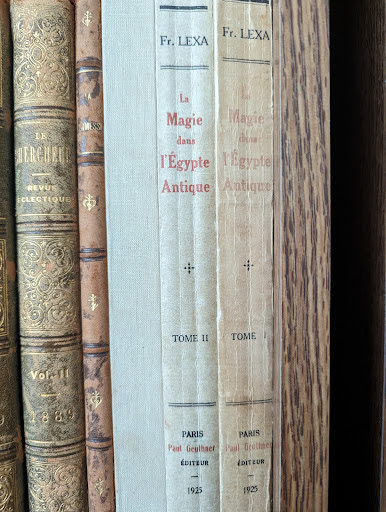

RuntimeError: "slow_conv2d_cpu" not implemented for 'Half'

In [6]:
#get all media item info

response = requests.get('https://photoslibrary.googleapis.com/v1/mediaItems', headers={'Authorization': f'Bearer {creds.token}'})
mediaItems = response.json()['mediaItems']

#loop through all the media items to get each base url and feed it to the captioning model function

baseUrls = []
times = []


for i in mediaItems:
    # baseUrls.append(i['baseUrl'])
    img = Image.open(requests.get(i['baseUrl'], stream=True).raw)
    display(img)
    caption_list = caption(img)
    print(caption_list)
    times.append(caption_list[1])
    print(statistics.fmean(times))
    avg = statistics.fmean(times)

In [ ]:
print(avg)